
Multimodal BNN-STGP

Haoyu Gu improved and commented the process


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model
import simulate

In [2]:
device = "cpu" # the device on which the model is trained, can be "cpu", "cuda" or "mps" ("mps" is only available for mac with M-series chip)
random_seed = 2025
r2 = 0.5 # true r2 of the simulated data
n = 1000 # simulation sample size
dim = 112 # dimensions of the simulated images
coord, true_beta, img_data, y = simulate.simulate_data(n, r2, dim, random_seed)

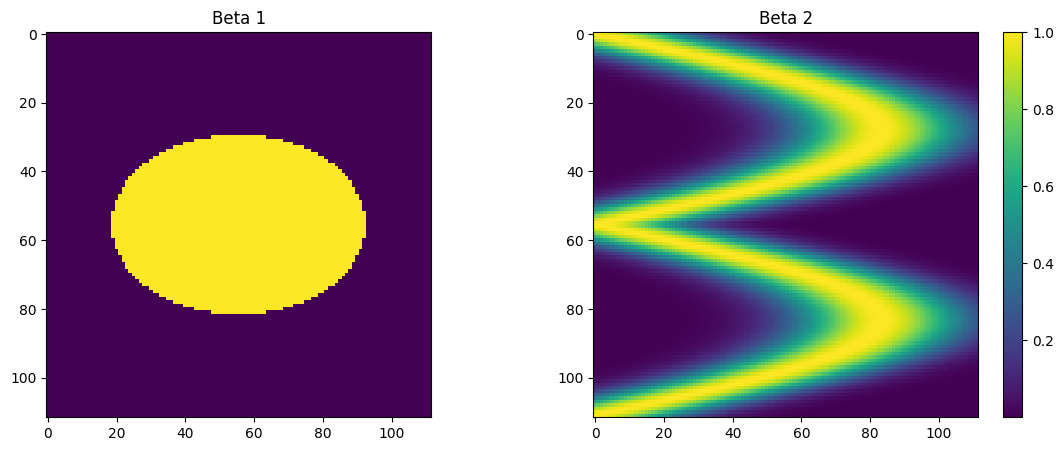

In [3]:
# plot true coefficients (beta1 and beta2) for the both image modalities
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

axs[0].imshow(true_beta[0].reshape(dim, dim))
axs[0].set_title("Beta 1")

cax = axs[1].imshow(true_beta[1].reshape(dim, dim))
axs[1].set_title("Beta 2")

fig.colorbar(cax, ax = axs[1])
plt.show();

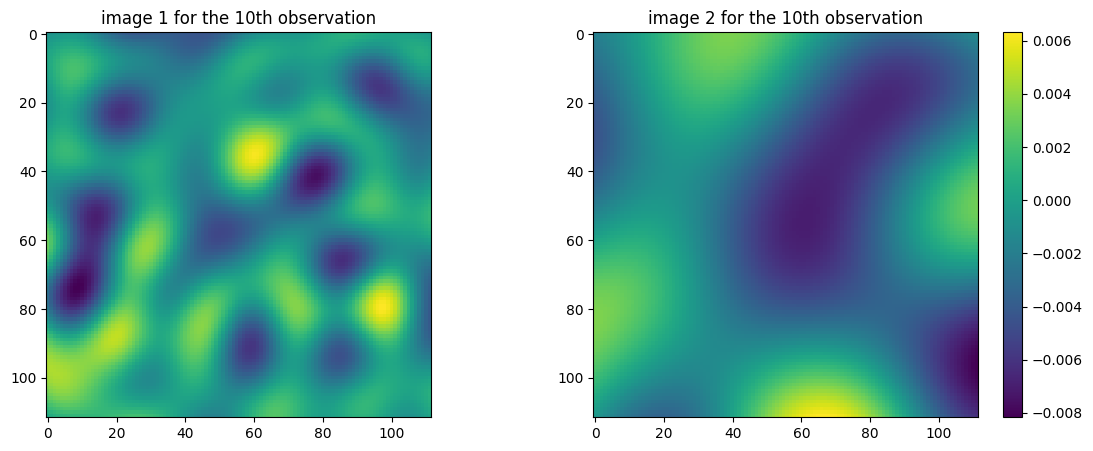

In [4]:
# plot the 10th image from the first image modality
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

axs[0].imshow(img_data[0][10].reshape(dim, dim))
axs[0].set_title("image 1 for the 10th observation")

cax = axs[1].imshow(img_data[1][10].reshape(dim, dim))
axs[1].set_title("image 2 for the 10th observation")

fig.colorbar(cax, ax = axs[1])
plt.show();

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# reshape image from 1d to 2d
img_data_0_reshaped = img_data[0].reshape(n, dim, dim)
img_data_1_reshaped = img_data[1].reshape(n, dim, dim)

# stack image 1 and image 2 for each observation

#Combines two image arrays along axis 1 (e.g., stack vertically or add channels)
stacked_img = np.concatenate([img_data_0_reshaped, img_data_1_reshaped], axis = 1)

# Adds a new axis to match CNN input requirements (adds a channel dimension)
# In Pytorch, CNNs expect 4D input: [Batch, Channels, Height, Width]. 
# Note that in TensorFlow, "channel last" format: [batch_size, height, width, channels] is expectede
# The code combines two images and adds the necessary channel dimension.
stacked_img = stacked_img[:, np.newaxis, :, :]

# create torch tensors

# Reshapes y into a 2D array with 1 column.
# -1 means "infer this dimension automatically" based on the number of elements.
# y = np.array([5, 10, 15])
# y.reshape(-1, 1) → [[5], [10], [15]]
# This is often done to prepare y as a column vector for regression tasks (e.g., shape [batch_size, 1]).
y = y.reshape(-1, 1)

# Converts the NumPy array y to a PyTorch tensor.
# Ensures it is of float32 type (standard for model input/targets).
# Moves it to the correct device: 'cpu' or 'cuda' (GPU).
y_tensor = torch.tensor(y, dtype = torch.float32).to(device)

# Converts the image data stacked_img (likely a NumPy array) to a PyTorch tensor.

# Uses float32 (needed for most models).
    # Depends on the loss function:
    # nn.MSELoss, nn.L1Loss: expects float32 targets
    # nn.CrossEntropyLoss: expects int64 (LongTensor) class indices
    # nn.BCELoss: expects float32 values in [0, 1]
    # nn.BCEWithLogitsLoss: same

# Sends the tensor to the selected device (GPU or CPU).
stacked_img_tensor = torch.tensor(stacked_img, dtype = torch.float32).to(device)

# set random seed
# Sets the seed for PyTorch's random number generator. 
# For running in CPU
torch.manual_seed(random_seed)

# Sets the seed for NumPy's random generator, ensuring that all 
# random numbers generated by NumPy are deterministic (repeatable). 
# For running in CPU
np.random.seed(random_seed)

# For running in CUDA, use these to ensure reproducibility
# torch.cuda.manual_seed_all(random_seed)  # for all CUDA devices
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


# split training and testing set and pass them into torch dataloaders
# stacked_img_tensor: your full input dataset (features)
# y_tensor: the corresponding target values (labels)
# test_size=0.2: 20% of the data will be used for testing; 80% for training
# random_state=random_seed: ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(stacked_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)

# wrap your input and target tensors (X_train, y_train, etc.) into PyTorch dataset objects 
# Combines your training features and labels into a single dataset object.
# Each item from train_dataset[i] returns (X_train[i], y_train[i]).
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# provide an efficient and flexible way to load and iterate over your dataset in mini-batches,
# DataLoader does these: Batching, Shuffling, Parallelisim, Memory pinning, and custom loading
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [ ]:
# training

# define neural network object and move the model to "device"
cnn = model.CNN2d().to(device)

# creates a Mean Squared Error loss function
criterion = torch.nn.MSELoss()

# creates an optimizer, using Adam optimization algorithm
# set learning rate, which controls how big a step the optimizer 
# takes when updating weights.
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)

num_epochs = 100
for epoch in range(num_epochs):

# set model to training mode
# this can also be put within "for X_batch, y_batch in train_loader", 
# which is slightly overhead from repetetion but safe
    cnn.train() 

# initialize running_loss and y_pred, y_true       
    running_loss = 0.0
    y_pred, y_true = [], []
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device) # this makes code more portable， it is necessary if run in GPU
        y_batch = y_batch.to(device) # this makes code more portable， it is necessary if run in GPU

#  Reset gradients before next step
        optimizer.zero_grad()

# Get model predictions (forward pass)
        y_hat_batch = cnn(X_batch)

# Measure how wrong the predictions are (compute loss)
        loss = criterion(y_hat_batch, y_batch)

# Computes gradients of the loss with respect to each parameter in the model.
# Uses backpropagation (chain rule of calculus).
# Gradients are stored in the .grad attribute of each parameter.
        loss.backward()

# Updates the model's parameters using the gradients computed above.
# Applies an optimization algorithm, like SGD or Adam.       
        optimizer.step()

# calculate cumulative loss
        running_loss += loss.item()
# detach()
# Detaches the tensor from the computation graph

# cpu()
# Moves the tensor to the CPU (in case it was on a GPU).

# numpy()
# This is necessary because NumPy only works with CPU tensors.
#         Converts the tensor to a NumPy array, which is useful for further analysis (e.g., computing R², saving to disk, plotting, etc.).
# flatten()

# Flattens the array to 1D
# Ensures a consistent shape, which simplifies concatenation or metric calculation.

        y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())

# No detach() due to that y_batch is not part of the computation graph.
# y_hat_batch is, because it's the output of the model and 
# requires gradients during training.
        y_true.extend(y_batch.cpu().numpy().flatten())

 # the code below works too, but torch.no_grad() is not needed in this situation
        # with torch.no_grad():
            # running_loss += loss.item()
            # y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
            # y_true.extend(y_batch.cpu().numpy().flatten())

    # print loss, training r2 and testing r2
    if (epoch + 1) % 5 == 0:

# R² score (coefficient of determination)
        train_r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Train R^2: {train_r2}")

    if (epoch + 1) % 5 == 0:
        cnn.eval()
        with torch.no_grad():
            X_test = X_test.to(device) # this makes code more portable， it is necessary if run in GPU
            y_test = y_test.to(device) # this makes code more portable， it is necessary if run in GPU
            y_hat_test = cnn(X_test).detach().cpu().numpy().flatten()
            test_r2 = np.corrcoef(y_test.cpu().numpy().flatten(), y_hat_test)[0, 1] ** 2
        print(f"Epoch {epoch + 1}, Test R^2: {test_r2}")

Epoch 5, Loss: 68.04175670623779, Train R^2: 0.5644411053442635
Epoch 5, Test R^2: 0.35690250171880766
Epoch 10, Loss: 48.16124523162842, Train R^2: 0.6907389342607756
Epoch 10, Test R^2: 0.31059319626727033
Epoch 15, Loss: 39.82408100128174, Train R^2: 0.7437157099184093
Epoch 15, Test R^2: 0.2791278564627632
Epoch 20, Loss: 36.196112422943116, Train R^2: 0.7669541267437254
Epoch 20, Test R^2: 0.31529272191908797
Epoch 25, Loss: 31.565871810913087, Train R^2: 0.796752203741349
Epoch 25, Test R^2: 0.3459191340184755
Epoch 30, Loss: 24.32022342681885, Train R^2: 0.8435429109194598
Epoch 30, Test R^2: 0.3172874250187401
Epoch 35, Loss: 29.681982192993164, Train R^2: 0.8098783756120453
Epoch 35, Test R^2: 0.3474510460876669
Epoch 40, Loss: 26.227241268157957, Train R^2: 0.8319802953721624
Epoch 40, Test R^2: 0.3325173280160319
Epoch 45, Loss: 23.124729795455934, Train R^2: 0.851045479785212
Epoch 45, Test R^2: 0.3734870202321095
Epoch 50, Loss: 20.157567863464354, Train R^2: 0.87011043376